<a href="https://colab.research.google.com/github/Alba251/face_detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alba251/face_detection.git
%cd face_detection


Cloning into 'face_detection'...
remote: Enumerating objects: 5013, done.
remote: Counting objects: 100% (5013/5013), done.
remote: Compressing objects: 100% (5011/5011), done.
remote: Total 5013 (delta 2), reused 5003 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5013/5013), 32.59 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/face_detection


In [2]:
#LIBRERIAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model




In [3]:
data = pd.read_csv("./data/data.csv", sep=';', dtype={'gender': str})
data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,male,70,111,107,111,37
1,1.jpg,male,71,110,106,111,31
2,2.jpg,male,71,111,106,110,37
3,3.jpg,male,68,111,108,112,51
4,4.jpg,male,71,111,106,110,36


In [4]:
print(data.describe())

       left_eye_x  left_eye_y  right_eye_x  right_eye_y          age
count  5000.00000  5000.00000   5000.00000  5000.000000  5000.000000
mean     69.39320   111.18780    107.60540   111.144200    37.074200
std       1.73931     1.12338      1.70689     1.179866     8.533819
min      60.00000   104.00000     93.00000   100.000000    11.000000
25%      68.00000   111.00000    107.00000   111.000000    32.000000
50%      69.00000   111.00000    108.00000   111.000000    35.000000
75%      70.00000   112.00000    109.00000   112.000000    40.000000
max      86.00000   117.00000    114.00000   122.000000    77.000000


In [5]:
#Conertimos la columan de male, female a binario

data['gender'] = data['gender'].map({'male':1, 'female':0})
data.head()


,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,70,111,107,111,37
1,1.jpg,1,71,110,106,111,31
2,2.jpg,1,71,111,106,110,37
3,3.jpg,1,68,111,108,112,51
4,4.jpg,1,71,111,106,110,36


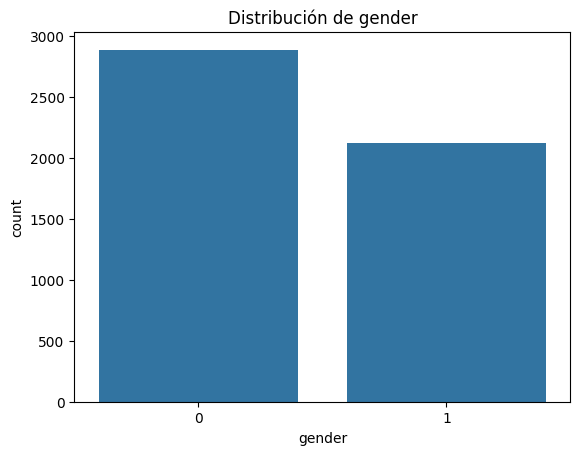

In [6]:
 #Ahora analizaremos cada variable
sns.countplot(x='gender', data=data)
plt.title("Distribución de gender")
plt.show()

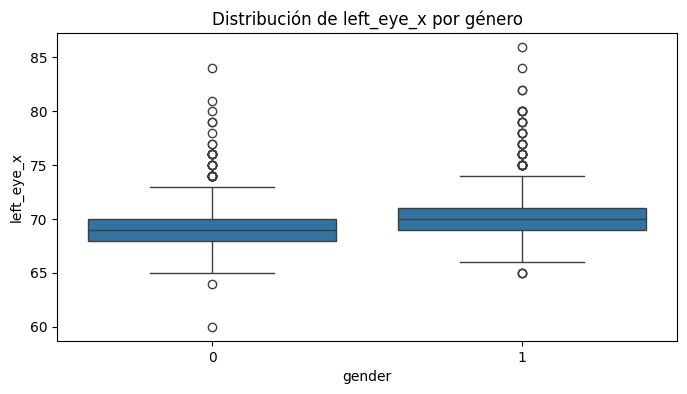

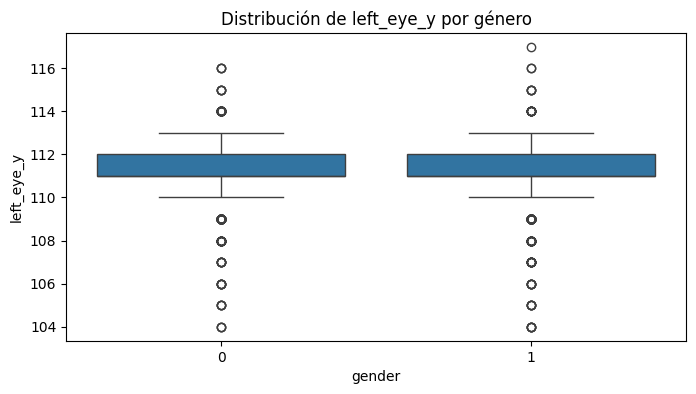

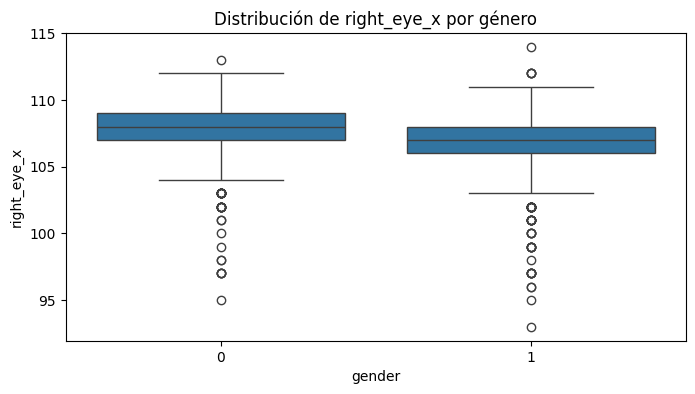

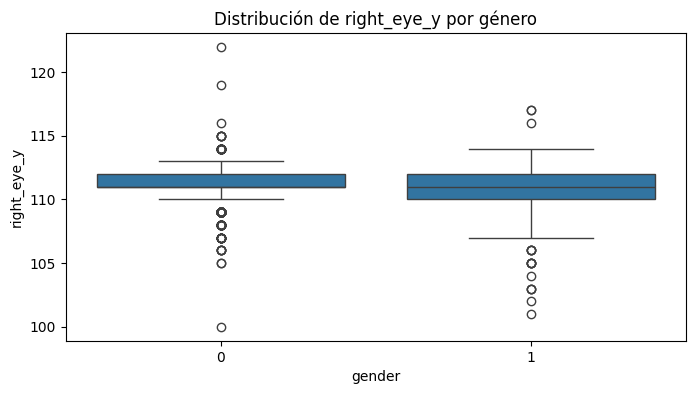

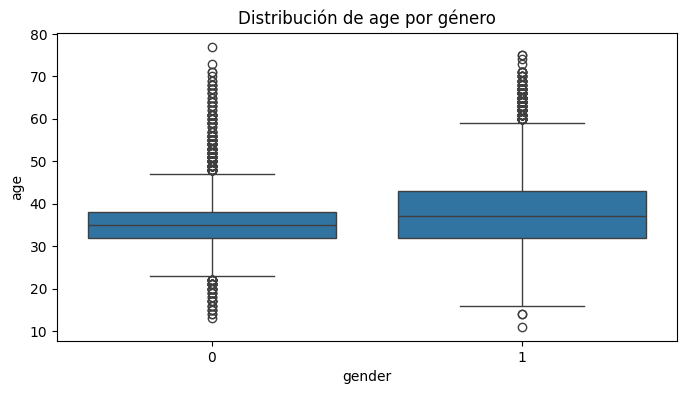

In [7]:
numerical_cols = ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'age']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='gender', y=col, data=data)
    plt.title(f'Distribución de {col} por género')
    plt.show()

#Tenemos resultados muy diferentes, lo que tiene sentido pq la persona puede estar desplazada...

In [14]:
#DIVIDIMOS EL DATASET EN TRAIN, TEST, VALIDATE

# Paso 1: dividir primero en train + temp (val+test)
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, eyes_train, eyes_temp = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.3,
    stratify=data['gender'],
    random_state=42
)

# Paso 2: dividir temp en val y test (mitad y mitad)
images_val, images_test, genders_val, genders_test, ages_val, ages_test, eyes_val, eyes_test = train_test_split(
    images_temp,
    genders_temp,
    ages_temp,
    eyes_temp,
    test_size=0.5,
    stratify=genders_temp,
    random_state=42
)


In [16]:
### Relacionar datos con imagenes para preparar el input del modelo

# Función para cargar y procesar la imagen
def load_and_preprocess_image(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # normaliza [0,1]
    # Aquí NO cambiamos tamaño para mantener 178x218 original
    return image

# Dataset de TensorFlow que yield (imagen, etiquetas)
def tf_data_generator(images, genders, ages, eyes):
    for i in range(len(images)):
        img = load_and_preprocess_image(images.iloc[i])  # usa .iloc si son pandas Series
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values  # ojo que eyes es DataFrame, pasamos a array
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels

def create_tf_dataset(images, genders, ages, eyes):
    return tf.data.Dataset.from_generator(
        lambda: tf_data_generator(images, genders, ages, eyes),
        output_signature=(
            tf.TensorSpec(shape=(218, 178, 3), dtype=tf.float32),
            {
                'gender': tf.TensorSpec(shape=(), dtype=tf.float32),
                'age': tf.TensorSpec(shape=(), dtype=tf.float32),
                'eye_pos': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            }
        )
    )

train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO
BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    pass  # solo itera, el print ya está en load_and_preprocess_image




In [10]:
# Input layer
input_img = Input(shape=(218, 178, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-10-426db0a79023>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
#ENTRENAMOS EL MODELO

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(images_train) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - age_loss: 9.8613 - age_mae: 2.4699 - eye_pos_loss: 2.2639 - eye_pos_mae: 1.1229 - gender_accuracy: 0.6998 - gender_loss: 0.5679 - loss: 12.6931

109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - age_loss: 9.8613 - age_mae: 2.4697 - eye_pos_loss: 2.2636 - eye_pos_mae: 1.1227 - gender_accuracy: 0.6998 - gender_loss: 0.5679 - loss: 12.6928 - val_age_loss: 188.8660 - val_age_mae: 12.1983 - val_eye_pos_loss: 43.6377 - val_eye_pos_mae: 4.3966 - val_gender_accuracy: 0.5761 - val_gender_loss: 0.7359 - val_loss: 233.2396
Epoch 2/10
  1/109 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - age_loss: 29.5716 - age_mae: 4.5464 - eye_pos_loss: 3.6898 - eye_pos_mae: 1.4214 - gender_accuracy: 0.6667 - gender_loss: 0.4851 - loss: 33.7464

109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - age_loss: 29.5716 - age_mae: 4.5464 - eye_pos_loss: 3.6898 - eye_pos_mae: 1.4214 - gender_accuracy: 0.6667 - gender_loss: 0.4851 - loss: 33.7464 - val_age_loss: 184.5298 - val_age_mae: 12.0427 - val_eye_pos_loss: 41.9081 - val_eye_pos_mae: 4.5464 - val_gender_accuracy: 0.5639 - val_gender_loss: 0.7369 - val_loss: 227.1747
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - age_loss: 11.8596 - age_mae: 2.6752 - eye_pos_loss: 2.2296 - eye_pos_mae: 1.1052 - gender_accuracy: 0.7009 - gender_loss: 0.5725 - loss: 14.6616

109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - age_loss: 11.8585 - age_mae: 2.6748 - eye_pos_loss: 2.2312 - eye_pos_mae: 1.1056 - gender_accuracy: 0.7008 - gender_loss: 0.5725 - loss: 14.6621 - val_age_loss: 163.2365 - val_age_mae: 11.4290 - val_eye_pos_loss: 55.4417 - val_eye_pos_mae: 5.6812 - val_gender_accuracy: 0.5897 - val_gender_loss: 1.0365 - val_loss: 219.7148
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - age_loss: 28.9636 - age_mae: 5.0114 - eye_pos_loss: 2.7654 - eye_pos_mae: 1.2330 - gender_accuracy: 0.6667 - gender_loss: 0.5047 - loss: 32.2337 - val_age_loss: 176.8872 - val_age_mae: 11.9736 - val_eye_pos_loss: 59.8330 - val_eye_pos_mae: 6.0182 - val_gender_accuracy: 0.5910 - val_gender_loss: 0.9030 - val_loss: 237.6233
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - age_loss: 10.9430 - age_mae: 2.5658 - eye_pos_loss: 2.1361 - eye_pos_mae: 1.0737 - gender_accuracy: 0.6978 - gender_loss: 0.5718 - loss: 13.6509 - val_age_loss: 159.7412 - val_age_mae: 11.3007 -

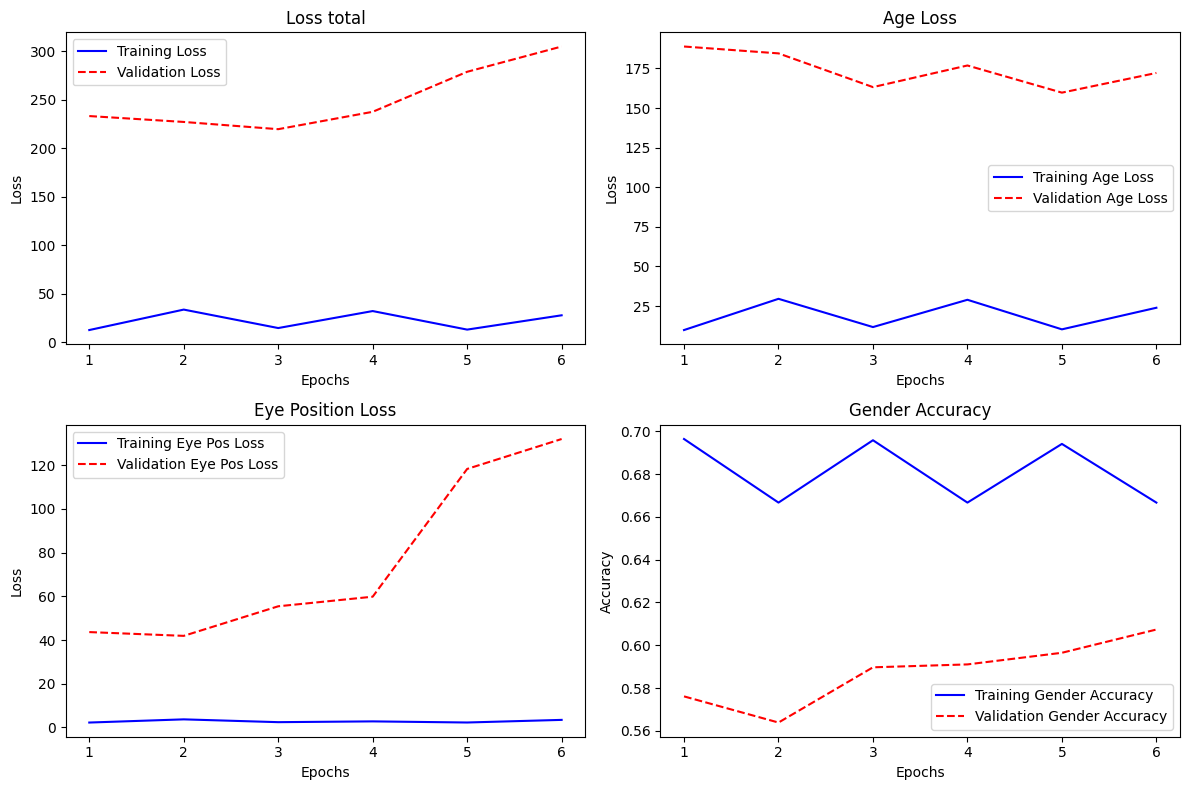

In [19]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss total vs val_loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss total')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot age_loss vs val_age_loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['age_loss'], 'b-', label='Training Age Loss')
    plt.plot(epochs, history.history['val_age_loss'], 'r--', label='Validation Age Loss')
    plt.title('Age Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot eye_pos_loss vs val_eye_pos_loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['eye_pos_loss'], 'b-', label='Training Eye Pos Loss')
    plt.plot(epochs, history.history['val_eye_pos_loss'], 'r--', label='Validation Eye Pos Loss')
    plt.title('Eye Position Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gender_accuracy vs val_gender_accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['gender_accuracy'], 'b-', label='Training Gender Accuracy')
    plt.plot(epochs, history.history['val_gender_accuracy'], 'r--', label='Validation Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con tu objeto history
plot_training_history(history)
